In [17]:
pip install tavily-python

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 3.0 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [tavily-python]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
api_key=os.getenv('groq_api')
travly=os.getenv('travly')
os.environ["TAVILY_API_KEY"] = travly


from typing import Annotated,TypedDict,Sequence
from langchain_core.messages import BaseMessage,SystemMessage,HumanMessage
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph,END,START
# The tools our agent can use
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode



In [101]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq

# Setup the LLM
# Use a smaller, faster model for the tool, and a larger one for the main agent
llm = ChatGroq(api_key=api_key,model="Gemma2-9b-It", temperature=0)

# 1. Load and process the documents for our RAG tool
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
all_splits = text_splitter.split_documents(docs)
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")
vectorstore = FAISS.from_documents(documents=all_splits, embedding=embedding_model)
retriever = vectorstore.as_retriever(k=4)

# 2. Create the RAG prompt
rag_prompt = PromptTemplate(
    template="""Use the following context to answer the question. 
    If you don't know the answer from the context, say that you cannot find the answer in the documents.

Context: {context}
Question: {question}
Answer:""",
    input_variables=["context", "question"],
)

# 3. Create the RAG chain
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

# You can test it: rag_chain.invoke("What are the components of an LLM-powered agent?")

In [102]:
rag_chain.invoke("What are the components of an LLM-powered agent?")

'According to the text, the components of an LLM-powered agent are:\n\n* **Planning:** This includes subgoal decomposition and self-reflection.\n* **Memory:**  This has both short-term memory (in-context learning) and long-term memory (often using an external vector store).\n* **Tool use:** The agent can call external APIs for information not included in its model weights. \n\n\n'

In [95]:
from langchain.tools import tool

@tool
def rag_tool(query: str) -> str:
    """Searches and answers questions about AI agent systems and their components based on a specific blog post."""
    return rag_chain.invoke(query)

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults

# The list of tools for our main agent
web_search_tool = TavilySearchResults(max_results=2)
tools = [rag_tool, web_search_tool]

# The main agent's state
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

# The main agent model (can be a more powerful one)
agent_model = ChatGroq(api_key=api_key,model="Gemma2-9b-It", temperature=0).bind_tools(tools)

# The graph nodes are the same as our previous ReAct agent
def call_model(state: AgentState):
    """Calls the agent model."""
    messages = state["messages"]
    response = agent_model.invoke(messages)
    return {"messages": [response]}

call_tool = ToolNode(tools=tools)

# The conditional edge is also the same
def should_continue(state: AgentState):
    """Decides whether to continue or end."""
    if state["messages"][-1].tool_calls:
        return "continue"
    return "end"

# Assemble the graph
graph = StateGraph(AgentState)
graph.add_node("agent", call_model)
graph.add_node("action", call_tool)
graph.set_entry_point("agent")
graph.add_conditional_edges("agent", should_continue, {"continue": "action", "end": END})
graph.add_edge("action", "agent")
app = graph.compile()

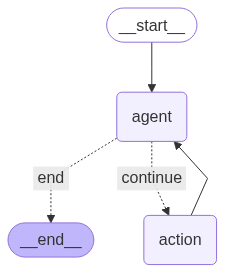

In [104]:
app

In [107]:
from langchain_core.messages import HumanMessage

# Scenario A
inputs = {"messages": [HumanMessage(content="Hi there, my name is Sahil. How are you?")]}

for event in app.stream(inputs, stream_mode="values"):
    event["messages"][-1].pretty_print()
    print("---")

================================ Human Message =================================

Hi there, my name is Sahil. How are you?
---
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (drv7sr477)
 Call ID: drv7sr477
  Args:
    query: How are you?
---
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What do you mean when you ask \"How are you?\"", "url": "https://english.stackexchange.com/questions/166153/what-do-you-mean-when-you-ask-how-are-you", "content": "The other answers are great, but I'd like to add that in Transactional Analysis the \"how are you?\" exchange is classified as a Ritual. \"How are you?\" is a way of giving and getting a basic attention and recognition, a way which is highly ritualised e.g. happens almost automatically and in a predefined fashion. [...] What do you mean when you ask this question? What answer do you want t

In [109]:
inputs = {"messages": [HumanMessage(content="who won last aus vs sa t20 match")]}

for event in app.stream(inputs, stream_mode="values"):
    event["messages"][-1].pretty_print()
    print("---")

================================ Human Message =================================

who won last aus vs sa t20 match
---
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (d74ak8emt)
 Call ID: d74ak8emt
  Args:
    query: who won last aus vs sa t20 match
---
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Australia beat South Africa by 17 runs, take 1-0 lead in three-match ...", "url": "https://timesofindia.indiatimes.com/sports/cricket/aus-vs-sa-live-score-today-cricket-match-australia-vs-south-africa-1st-t20i-live-updates-scorecard-travis-head-aiden-markram/liveblog/123216145.cms", "content": "Both teams entered the series with strong line-ups and fresh momentum, with South Africa focused on moving past their recent World Test Championship defeat to Australia. The match represented the start of a critical build-up to the 2026 T20 World C

In [110]:
# Scenario B
inputs = {"messages": [HumanMessage(content="What are the main components of an LLM-powered autonomous agent system?")]}

for event in app.stream(inputs, stream_mode="values"):
    event["messages"][-1].pretty_print()
    print("---")

================================ Human Message =================================

What are the main components of an LLM-powered autonomous agent system?
---
================================== Ai Message ==================================
Tool Calls:
  rag_tool (1r055nazv)
 Call ID: 1r055nazv
  Args:
    query: What are the main components of an LLM-powered autonomous agent system?
---
================================= Tool Message =================================
Name: rag_tool

According to the text, the main components of an LLM-powered autonomous agent system are:

* **Planning:** This includes subgoal decomposition and self-reflection.
* **Memory:**  This consists of short-term memory (in-context learning) and long-term memory (often using an external vector store).
* **Tool use:** The agent learns to use external APIs for information and capabilities not included in its model weights. 



---
================================== Ai Message ==================================

Accor